<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

	Google Colaboratory
	PostgreSQL
	GitHub	     
	Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
	Code Developed by
	Carlos Mendez
	Sebastian Palomino
	Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [1]:
###################################### Artificial Intelligence Frameworks #####################################################
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.5 MB/s eta 0:00:00


# Import libraries and packages

In [21]:
## AI packages
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.exceptions import UndefinedMetricWarning

## Geoprocessing packages
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gc  # Garbage collector to free memory
import os
import contextily as ctx
from shapely.geometry import box
import seaborn as sns
import joblib
import urllib.request
import warnings

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 833, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 833 (delta 93), reused 55 (delta 51), pack-reused 699 (from 1)
Receiving objects: 100% (833/833), 3.13 GiB | 27.27 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Updating files: 100% (319/319), done.


# Prepare data and first steps

## Import Sentinel-1 Raster Images (VH-VV) and create Polarization Ratio (PR) index

In [4]:
## Access the VH Path
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH"
## Access the VV Path
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VV"
## Create the PR Index path
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/PR_index"

# Create output directory if it doesn't exist
os.makedirs(pr_path, exist_ok=True)

# List VH and VV files (assuming matching filenames)
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")]) # Search files ending with .tif
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")]) # Search files ending with .tif

# Loop through files and compute PR index scaled between 0 and 1
for vh_file, vv_file in zip(vh_files, vv_files):
    # Read the vh_files and vv_files
    with rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(vv_path, vv_file)) as vv_src:

        vh = vh_src.read(1).astype("float32") # Converts the data to 32-bit float
        vv = vv_src.read(1).astype("float32") # Converts the data to 32-bit float

        pr_index_diff = vh - vv  # Compute PR index as difference

        # Save PR index difference
        profile = vh_src.profile
        profile.update(dtype="float32", count=1)

        pr_filename = f"PR_diff_{vh_file}"
        with rasterio.open(os.path.join(pr_path, pr_filename), "w", **profile) as dst:
            dst.write(pr_index_diff, 1)

print("PR index (VH - VV) computation complete.")

PR index (VH - VV) computation complete.


## Calculate General Statistics (minimum and maximum values)

In [5]:
def get_min_max_from_folder(folder_path): # Create a function to scan .tif images
    min_val = np.inf # initialize with the min values
    max_val = -np.inf # initialize with the max values

    for filename in sorted(os.listdir(folder_path)): # Begins a loop that iterates through all files in a folder
        if filename.endswith('.tif'):# Search files ending with .tif
            file_path = os.path.join(folder_path, filename) # Read the files using the path and filename
            with rasterio.open(file_path) as src: # Opens a raster file using rasterio
                data = src.read(1) #reads the first band of the raster file
                # Mask out no-data values if needed
                if src.nodata is not None: # Checks if the data include nodata values
                    data = np.ma.masked_equal(data, src.nodata) # Masks out all pixels without nodata
                min_val = min(min_val, data.min()) # Calculate and update the minimum values across all raster files
                max_val = max(max_val, data.max()) # Calculate and update the maximum values across all raster files

    return min_val, max_val #Return the min and max values

# Call the function and calculate min and max values in vh, vv and pr
vh_min, vh_max = get_min_max_from_folder(vh_path)
vv_min, vv_max = get_min_max_from_folder(vv_path)
pr_min, pr_max = get_min_max_from_folder(pr_path)

#Print the results
print(f"VH min: {vh_min}, VH max: {vh_max}")
print(f"VV min: {vv_min}, VV max: {vv_max}")
print(f"PR min: {pr_min}, PR max: {pr_max}")

VH min: -63.30115509033203, VH max: 14.939030647277832
VV min: -47.164337158203125, VV max: 23.44919204711914
PR min: -47.79340744018555, PR max: 21.402484893798828


## Plot and visualize the Polarizaton Ratio (PR)

In [ ]:
''''
def visualize_images_grid_percentile(folder_path, title_prefix="PR Index"): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, images_per_fig, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:

                    # Compute 2nd and 98th percentiles
                    p2 = np.nanpercentile(data, 2)
                    p98 = np.nanpercentile(data, 98)

                    # Clip data to percentile range
                    stretched = np.clip(data, p2, p98)

                    # Plot the images
                    im = axes[j].imshow(stretched, cmap='viridis', vmin=p2, vmax=p98)
                    axes[j].set_title(f"{filename}", fontsize=8) # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()
'''

'\'\ndef visualize_images_grid_percentile(folder_path, title_prefix="PR Index"): # Create a function with (folder_path, title_prefix) as parameters\n    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith(\'.tif\')]) # Search and scan in the path all raster images ending with .tif\n    num_files = len(tif_files) # Calculate the number and total of files\n    images_per_fig = 6 # Configure the number of images per figure\n\n    for i in range(0, num_files, images_per_fig): # Initialize the looping\n        fig, axes = plt.subplots(1, images_per_fig, figsize=(18, 3)) # Configure the subplots and size of images (18x3)\n        axes = axes.flatten() # Specify that the axes are a flat 1D array\n\n        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:\n            idx = i + j # Calculates the index of the current image file to be processed:\n            if idx < num_files: # Verify the index is lower than numbe

In [ ]:
#visualize_images_grid_percentile(pr_path, title_prefix="PR Index")

## Plot and visualize the VH and VV images

In [6]:
def visualize_images_grid(folder_path, vmin, vmax, title_prefix): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, 6, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:
                    im = axes[j].imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
                    axes[j].set_title(filename, fontsize=10)  # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')  # Hide unused subplot

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


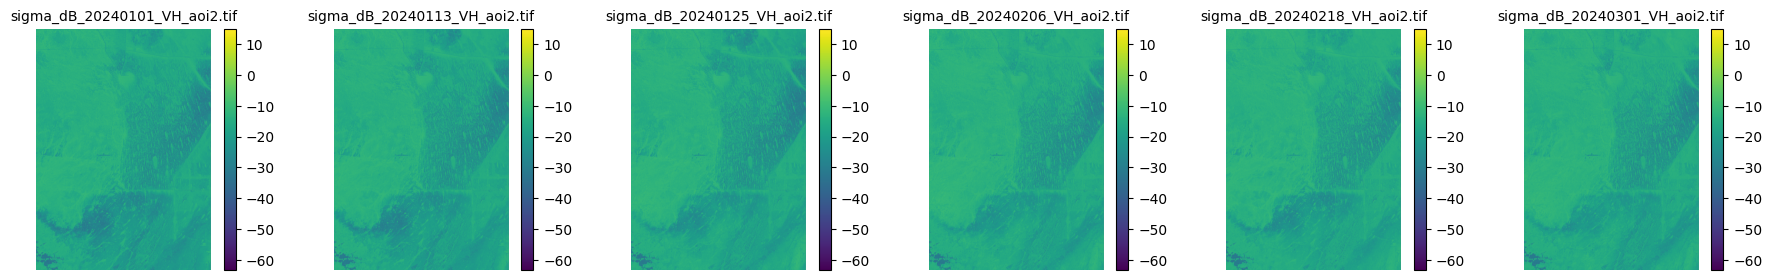

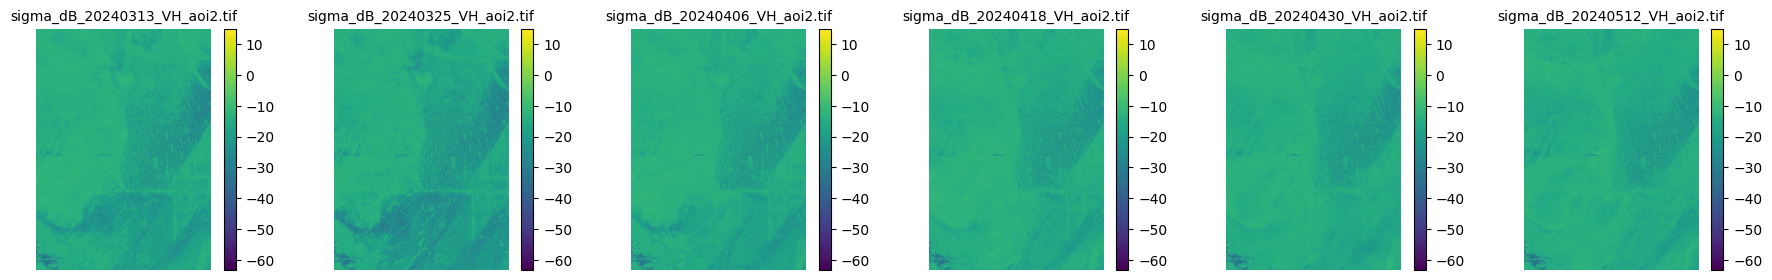

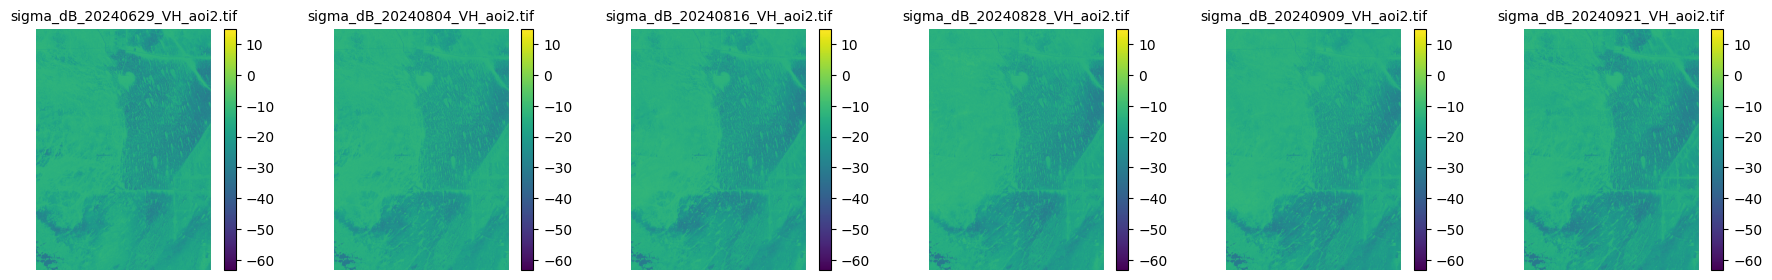

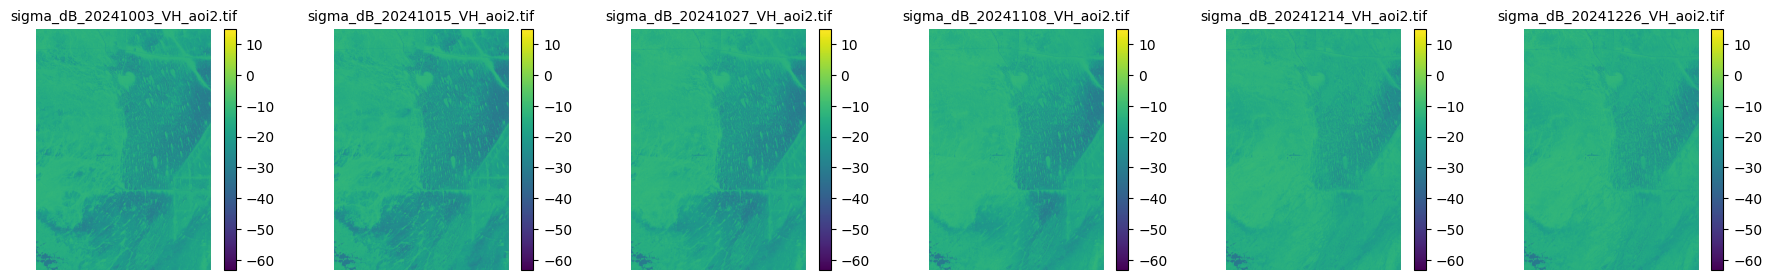

In [7]:
# Visualize each image with consistent scaling
visualize_images_grid(vh_path, vh_min, vh_max, "VH")

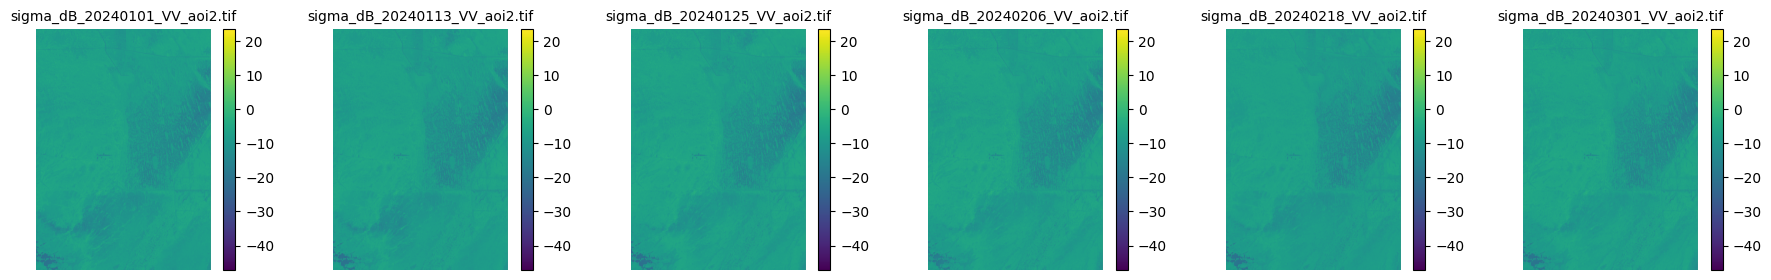

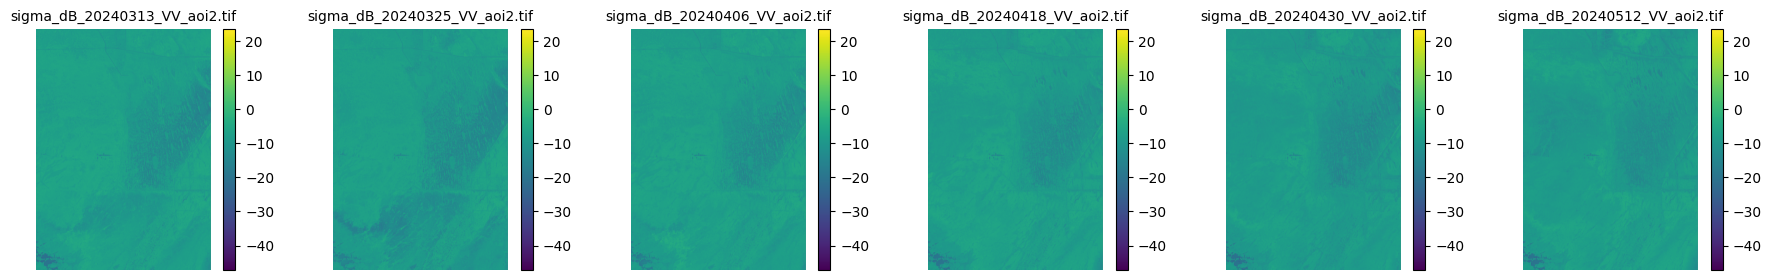

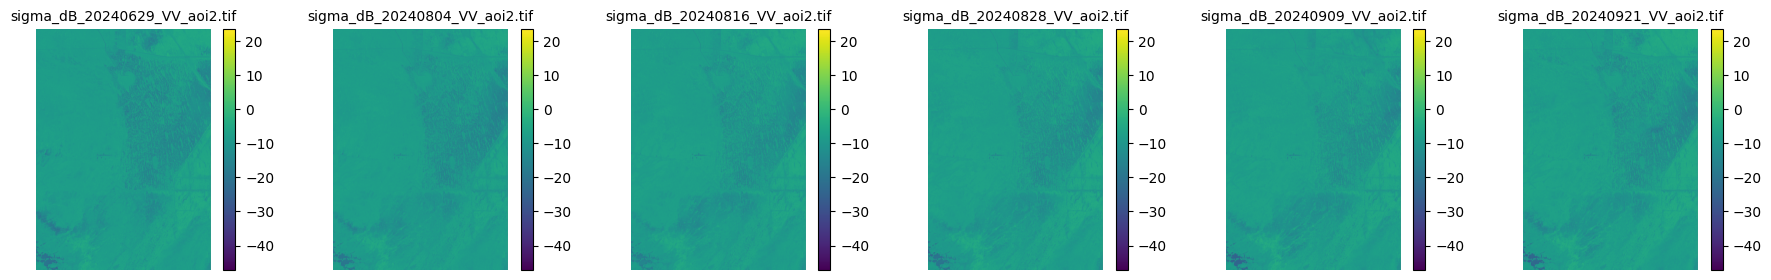

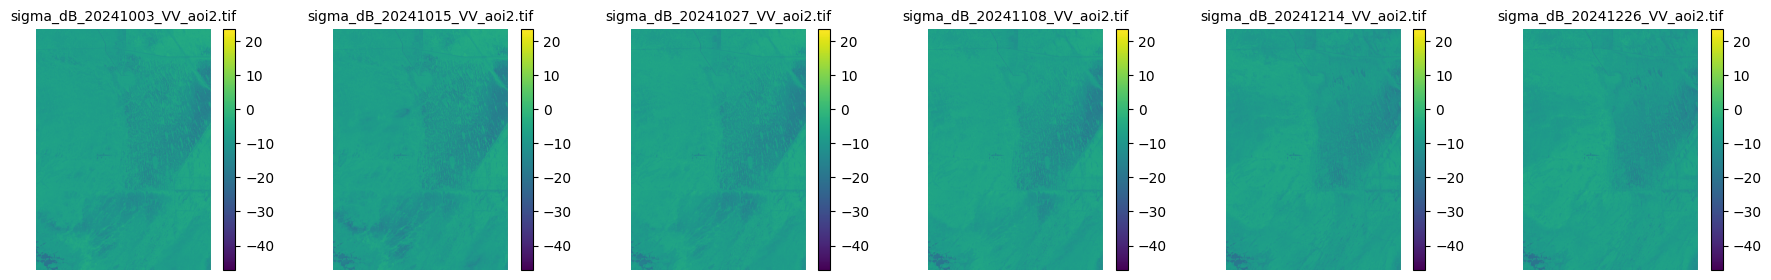

In [8]:
# Visualize each image with consistent scaling
visualize_images_grid(vv_path, vv_min, vv_max, "VV")

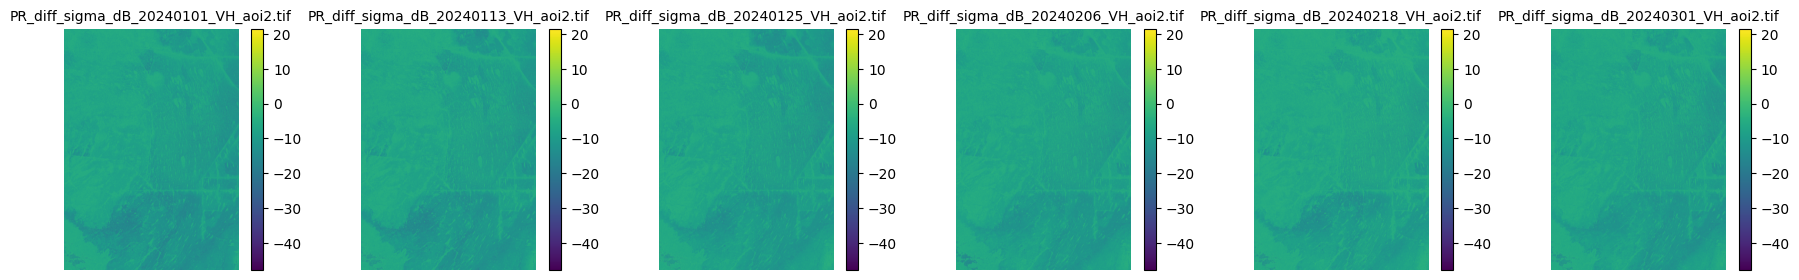

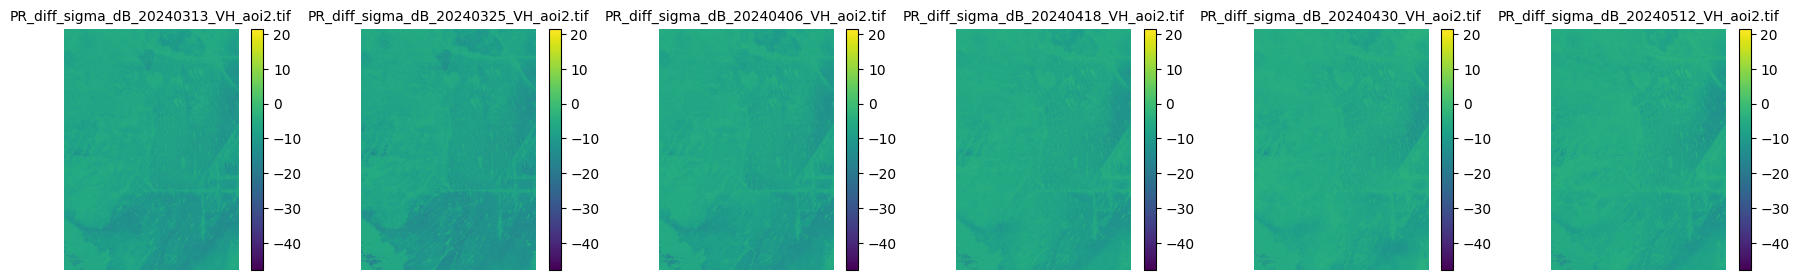

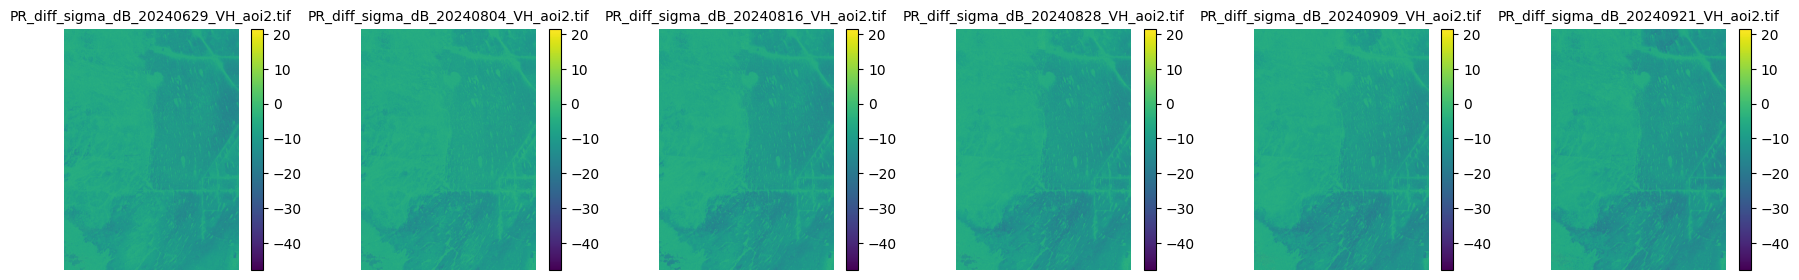

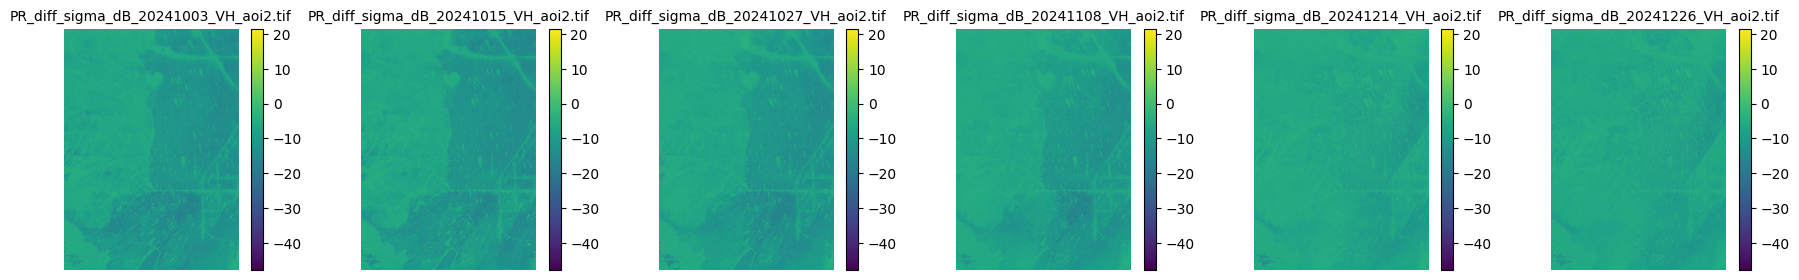

In [9]:
# Visualize each image with consistent scaling
visualize_images_grid(pr_path, pr_min, pr_max, "PR")

## Combine VH-VV-PR data

In [5]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)
pr_images = load_images(pr_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
print(f"System recognized {pr_images.shape[0]} images of PR Index with size {pr_images.shape[1:]} each one.")

assert vh_images.shape == vv_images.shape == pr_images.shape, "The dimensions and size of VH-VV-PR are equal"

# Combine the VH-VV-PR polarization with the same size and dimensions
master_data = np.stack([vh_images, vv_images, pr_images], axis=-1)  # (n_images)

print(f"System combine the VH-VV-PR polarizations wit the size {master_data.shape}")

System recognized 24 images VH polarization with size (3875, 2804) each one.
System recognized 24 images VV polarization with size (3875, 2804) each one.
System recognized 24 images of PR Index with size (3875, 2804) each one.
System combine the VH-VV-PR polarizations wit the size (24, 3875, 2804, 3)


# Import points (.shp) with labels and marks

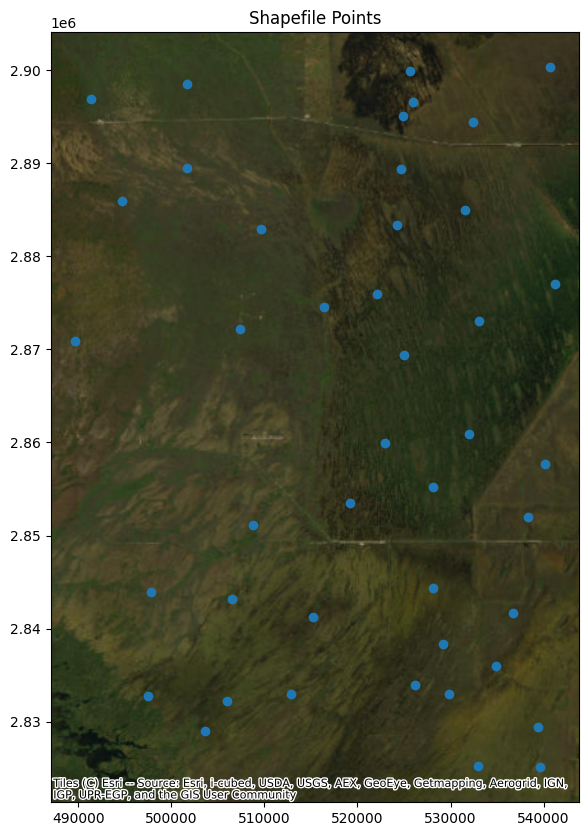

In [6]:
# Load shapefile
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi2/points_AOI2_BDE.shp"
gdf = gpd.read_file(shapefile_path)

#providers = ctx.providers
#providers

# Plot the .shp
ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title('Shapefile Points')
plt.show()

## Verify Coordinate Reference System (CRS)

In [7]:
# Open a reference raster to get CRS and bounds
with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref:
    raster_crs = ref.crs
    raster_bounds = box(*ref.bounds)

print("The Coordinate Reference System (CRS) is:", raster_crs)

# Reproject shapefile to match raster CRS
gdf = gdf.to_crs(raster_crs)

print("Bounds image:", ref.bounds)
print("Bounds shapefile:", gdf.total_bounds)

# Filter points that fall within the raster extent
gdf_filtered = gdf[gdf.geometry.within(raster_bounds)]
print(f"Points inside raster: {len(gdf_filtered)} of {len(gdf)}")

The Coordinate Reference System (CRS) is: EPSG:32617
Bounds image: BoundingBox(left=488300.0, bottom=2823700.0, right=544380.0, top=2901200.0)
Bounds shapefile: [ 489599.51383088 2825091.04763268  541222.74691443 2900327.16197831]
Points inside raster: 43 of 43


## Create Matrix and Dataframe

In [8]:
# Define label columns
label_columns = [
    '1_01_2024_', '1_13_2024_', '1_25_2024_', '2_06_2024_', '2_18_2024_', '3_01_2024_',
    '3_13_2024_', '3_25_2024_', '4_06_2024_', '4_18_2024_', '4_30_2024_', '5_12_2024_',
    '6_29_2024_', '8_04_2024_', '8_16_2024_', '8_28_2024_', '9_09_2024_', '9_21_2024_',
    '10_03_2024', '10_15_2024', '10_27_2024', '11_08_2024', '12_14_2024', '12_26_2024'
]
labels_df = gdf[label_columns]

# Preview the label matrix
print("Extracted label matrix:")
print(labels_df.head(43))

Extracted label matrix:
   1_01_2024_ 1_13_2024_ 1_25_2024_ 2_06_2024_ 2_18_2024_ 3_01_2024_  \
0         e11        e11        e11        e11        e21        e21   
1         e21        e21        e21        e21        e21        e21   
2         e21        e21        e21        e21        e21        e21   
3         e22        e22        e22        e22        e22        e22   
4         e21        e21        e21        e21        e21        e21   
5         e21        e21        e21        e21        e21        e21   
6         e23        e23        e23        e23        e13        e13   
7         e23        e23        e23        e23        e23        e23   
8         e23        e23        e23        e23        e23        e23   
9         e21        e21        e21        e21        e21        e21   
10        e21        e21        e21        e21        e21        e21   
11        e21        e11        e11        e11        e11        e11   
12        e23        e23        e23     

In [9]:
label_encoders = {}
y_encoded = pd.DataFrame()

for col in labels_df.columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(labels_df[col])
    label_encoders[col] = le

In [10]:
print(y_encoded)
for col in labels_df.columns[:24]:  # Sample a few columns
    print(f"{col} original: {labels_df[col].unique()}")
    print(f"{col} encoded: {y_encoded[col].unique()}")

joblib.dump(label_encoders, "label_encoders.pkl")

    1_01_2024_  1_13_2024_  1_25_2024_  2_06_2024_  2_18_2024_  3_01_2024_  \
0            0           0           0           0           2           2   
1            1           1           1           1           2           2   
2            1           1           1           1           2           2   
3            2           2           2           2           3           3   
4            1           1           1           1           2           2   
5            1           1           1           1           2           2   
6            3           3           3           3           1           1   
7            3           3           3           3           4           4   
8            3           3           3           3           4           4   
9            1           1           1           1           2           2   
10           1           1           1           1           2           2   
11           1           0           0           0           0  

['label_encoders.pkl']

## Calculate only pixels inside coordinate points(.shp)

In [11]:
# Function to get pixel coordinates
def get_pixel_coords(src, point): # Create function with (src and point) as parameters
    return src.index(point.x, point.y) # Returns the values converted from geographic coordinates (point.x and point.y)

with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref: # Open the raster files and then get pixel values
    features = [] # Create an empty list
    for point in gdf.geometry: # Loop to operate through each geometry
        try:
            row, col = get_pixel_coords(ref, point) # Converts geographic point into raster pixel
            pixel_values = master_data[:, row, col, :].flatten() # extracting a time-series feature vector for a single spatial point
        except IndexError: #Exception
            pixel_values = [np.nan] * (master_data.shape[0] * 3) # handle cases where a point falls outside the raster bounds, not receive the three number bands (VH,VV,PR)
        features.append(pixel_values) # appends the extracted or fallback pixel values to your features list:

# Convert to NumPy array
X = np.array(features)

# Check for NaNs
print(f"Rows with NaNs: {np.isnan(X).any(axis=1).sum()} of {X.shape[0]}")

Rows with NaNs: 0 of 43


# Create Random Forest Classifier Model

## Create RF using grid search for each label column separately

### Configure best Hyperparameters

In [12]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define hyperparameter grid
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2']
}

# Filter valid rows (no NaNs in features or labels)
valid_mask = ~np.isnan(X).any(axis=1) & ~y_encoded.isnull().any(axis=1)
X_clean = X[valid_mask]
y_clean = y_encoded[valid_mask]

### Training (70%) and validation (30%) model and visualize (precision, score and performance)

In [13]:
# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42)

# Initialize base classifier and wrap with MultiOutputClassifier
base_rf = RandomForestClassifier(random_state=42)
multi_rf = MultiOutputClassifier(base_rf)

# Grid search for multi-output
grid_search = GridSearchCV(estimator=multi_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_tr, y_tr)

# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_te)

# Save model
joblib.dump(best_model, "multi_rf_model.pkl")

# Evaluate each output
for i, col in enumerate(y_encoded.columns):
    print(f"\n📅 Results for {col}")
    print("Confusion Matrix:\n", confusion_matrix(y_te.iloc[:, i], y_pred[:, i]))
    print("Classification Report:\n", classification_report(y_te.iloc[:, i], y_pred[:, i]))
    print("Accuracy:", accuracy_score(y_te.iloc[:, i], y_pred[:, i]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits

📅 Results for 1_01_2024_
Confusion Matrix:
 [[0 1 0 0]
 [0 6 1 0]
 [0 2 0 0]
 [0 3 0 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.86      0.63         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3

    accuracy                           0.46        13
   macro avg       0.12      0.21      0.16        13
weighted avg       0.27      0.46      0.34        13

Accuracy: 0.46153846153846156

📅 Results for 1_13_2024_
Confusion Matrix:
 [[0 2 0 0]
 [0 5 1 0]
 [0 2 0 0]
 [0 3 0 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.42      0.83      0.56         6
           2       0.00      0.00      0.00         2
           3       0.00     

### Show the best Accuracy Random Forest Model

In [14]:
# Predict on test set
y_pred = best_model.predict(X_te)

# Compute accuracy per label
label_accuracies = {}
for i, col in enumerate(y_te.columns):
    acc = accuracy_score(y_te.iloc[:, i], y_pred[:, i])
    label_accuracies[col] = acc

# Identify best-performing label
best_label = max(label_accuracies, key=label_accuracies.get)
best_accuracy = label_accuracies[best_label]

print(f"\n✅ Best-performing label: {best_label}")
print(f"🎯 Accuracy: {best_accuracy:.4f}")

# Save the full multi-output model
joblib.dump(best_model, "best_multi_rf_model.pkl")


✅ Best-performing label: 6_29_2024_
🎯 Accuracy: 0.5385


['best_multi_rf_model.pkl']

### Plot the metrics and statistics

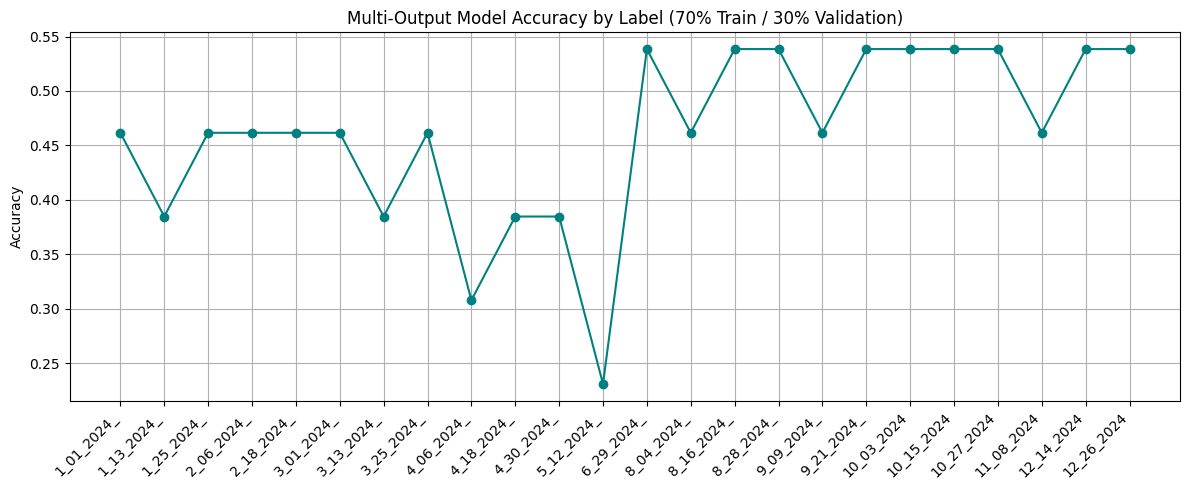

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(list(label_accuracies.keys()), list(label_accuracies.values()),
         marker='o', linestyle='-', color='teal')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Multi-Output Model Accuracy by Label (70% Train / 30% Validation)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create backup to upload manually and reload RF model if system restarted

In [17]:
from google.colab import files
uploaded = files.upload()

# Load model
best_model = joblib.load("best_multi_rf_model.pkl")

# Load label encoders
label_encoders = joblib.load("label_encoders.pkl")

Saving best_multi_rf_model_backup.pkl to best_multi_rf_model_backup.pkl
Saving multi_rf_model_backup.pkl to multi_rf_model_backup.pkl
Saving label_encoders_backup.pkl to label_encoders_backup.pkl


In [19]:
print("Loaded model:", type(best_model))
print("Loaded encoders:", list(label_encoders.keys())[:24])  # Show sample keys

Loaded model: <class 'sklearn.multioutput.MultiOutputClassifier'>
Loaded encoders: ['1_01_2024_', '1_13_2024_', '1_25_2024_', '2_06_2024_', '2_18_2024_', '3_01_2024_', '3_13_2024_', '3_25_2024_', '4_06_2024_', '4_18_2024_', '4_30_2024_', '5_12_2024_', '6_29_2024_', '8_04_2024_', '8_16_2024_', '8_28_2024_', '9_09_2024_', '9_21_2024_', '10_03_2024', '10_15_2024', '10_27_2024', '11_08_2024', '12_14_2024', '12_26_2024']


# Create backup from GitHub to upload and reload RF model if system restarted

In [25]:
# Load model
model_url = "https://raw.githubusercontent.com/sei-latam/WETSAT_v2/main/2_Modelling_WETSAT_Google_Colab/best_multi_rf_model_backup.pkl"
urllib.request.urlretrieve(model_url, "best_multi_rf_model.pkl")
best_model = joblib.load("best_multi_rf_model.pkl")

# Load encoders
encoder_url = "https://raw.githubusercontent.com/sei-latam/WETSAT_v2/main/2_Modelling_WETSAT_Google_Colab/label_encoders_backup.pkl"
urllib.request.urlretrieve(encoder_url, "label_encoders.pkl")
label_encoders = joblib.load("label_encoders.pkl")

# Start predictions using the best RF Model

In [ ]:
# 1. Reshape master_data: each row = pixel, each column = feature
n_dates, height, width, n_bands = master_data.shape
n_pixels = height * width

reshaped_data = master_data.reshape(n_dates, n_pixels, n_bands) \
                            .transpose(1, 0, 2) \
                            .reshape(n_pixels, -1) \
                            .astype("float32")  # Reduce memory usage

In [ ]:
# 2. Predict in batches to avoid RAM overload
def predict_in_batches(data, model, batch_size=2000):
    n_samples = data.shape[0]
    predictions = []

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch = data[start:end]
        batch_pred = model.predict(batch)
        predictions.append(batch_pred)
        gc.collect()  # Free memory

    return np.vstack(predictions)

predictions = predict_in_batches(reshaped_data, best_model, batch_size=2000)

In [ ]:
# 3. Reconstruct predicted maps (numeric labels)
predicted_maps = {
    label: predictions[:, i].reshape(height, width)
    for i, label in enumerate(y_encoded.columns)
}

In [ ]:
# 4. Decode predictions one label at a time (on-demand)
def decode_label_map(label, encoded_map):
    encoder = label_encoders[label]
    decoded = encoder.inverse_transform(encoded_map.flatten())
    return decoded.reshape(encoded_map.shape)


In [ ]:
# 5. Visualization function using original labels
def plot_label_map(label, label_matrix):
    unique_labels = np.sort(np.unique(label_matrix))
    label_to_int = {lbl: i for i, lbl in enumerate(unique_labels)}
    int_matrix = np.vectorize(label_to_int.get)(label_matrix)

    cmap = plt.get_cmap('tab20', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels)+1)-0.5, ncolors=len(unique_labels))

    plt.figure(figsize=(8, 6))
    im = plt.imshow(int_matrix, cmap=cmap, norm=norm)
    plt.title(f"Predicted Map for {label}")
    plt.axis('off')
    cbar = plt.colorbar(im, ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    cbar.set_label("Predicted Class")
    plt.tight_layout()
    plt.show()


In [ ]:
# 6. Visualize the best-performing label
decoded_map = decode_label_map(best_label, predicted_maps[best_label])
plot_label_map(best_label, decoded_map)
del decoded_map  # Free memory
gc.collect()

In [ ]:
import rasterio
from rasterio.transform import from_origin

# Reference raster for metadata
with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref:
    transform = ref.transform
    crs = ref.crs

# Export each decoded map one at a time
for label in y_encoded.columns:
    print(f"📝 Exporting map for {label}...")

    # Get numeric prediction map
    encoded_map = predicted_maps[label]

    # Decode to original labels
    decoded = label_encoders[label].inverse_transform(encoded_map.flatten())
    decoded_map = decoded.reshape(encoded_map.shape)

    # Convert string labels to integers for saving (optional)
    unique_labels = np.unique(decoded_map)
    label_to_int = {lbl: i for i, lbl in enumerate(unique_labels)}
    int_map = np.vectorize(label_to_int.get)(decoded_map).astype("uint8")

    # Save as GeoTIFF
    output_path = f"predicted_map_{label}.tif"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=int_map.shape[0],
        width=int_map.shape[1],
        count=1,
        dtype="uint8",
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(int_map, 1)

    # Free memory
    del decoded_map, int_map
    gc.collect()

print("✅ All maps exported as GeoTIFFs.")

In [21]:
# 1. Reorganizar master_data para que cada fila sea un píxel y cada columna una característica
n_dates, height, width, n_bands = master_data.shape
n_pixels = height * width

reshaped_data = master_data.reshape(n_dates, n_pixels, n_bands) \
                            .transpose(1, 0, 2) \
                            .reshape(n_pixels, -1)


In [ ]:
# 2. Aplicar el modelo multietiqueta entrenado
predictions = best_model.predict(reshaped_data)  # shape: (n_pixels, n_labels)

In [ ]:
# 3. Reconstruir mapas por etiqueta (valores numéricos)
predicted_maps = {}
for i, label in enumerate(y_encoded.columns):
    predicted_maps[label] = predictions[:, i].reshape(height, width)

In [ ]:
# 4. Decodificar etiquetas originales usando los LabelEncoders
decoded_maps = {}
for i, label in enumerate(y_encoded.columns):
    encoder = label_encoders[label]
    decoded_maps[label] = encoder.inverse_transform(predicted_maps[label].flatten()) \
                                       .reshape(predicted_maps[label].shape)

In [ ]:
# 5. Función para visualizar mapas con etiquetas originales
def plot_label_map(label, label_matrix):
    unique_labels = np.unique(label_matrix)
    label_to_int = {lbl: i for i, lbl in enumerate(unique_labels)}
    int_matrix = np.vectorize(label_to_int.get)(label_matrix)

    cmap = plt.get_cmap('tab20', len(unique_labels))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels)+1)-0.5, ncolors=len(unique_labels))

    plt.figure(figsize=(8, 6))
    im = plt.imshow(int_matrix, cmap=cmap, norm=norm)
    plt.title(f"Predicted Map for {label}")
    plt.axis('off')
    cbar = plt.colorbar(im, ticks=np.arange(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    plt.tight_layout()
    plt.show()

In [ ]:
# 6. Visualizar el mapa para la mejor etiqueta
plot_label_map(best_label, decoded_maps[best_label])

In [ ]:
# Dimensiones del stack
n_dates, height, width, n_bands = master_data.shape
n_pixels = height * width

# Reorganizar datos: cada fila es un píxel, cada columna es una característica
reshaped_data = master_data.reshape(n_dates, n_pixels, n_bands).transpose(1, 0, 2).reshape(n_pixels, -1)

# Predecir clases por fecha
predictions = best_model.predict(reshaped_data)  # shape: (n_pixels, n_labels)

# Reconstruir mapas por etiqueta
predicted_maps = {}
for i, label in enumerate(y_encoded.columns):
    predicted_maps[label] = predictions[:, i].reshape(height, width)

# Load the pre-trained Random Forest stored in Colab

In [ ]:
model = joblib.load("best_multi_rf_model.pkl")

In [ ]:
# Predict on full raster
height, width = master_data.shape[1:3]
X_pixels = master_data.reshape(-1, master_data.shape[0] * 3)
y_pixel_pred = best_model.predict(X_pixels)

In [ ]:
y_maps = {}
for i, col in enumerate(y_encoded.columns):
    y_maps[col] = y_pixel_pred[:, i].reshape(height, width)

In [ ]:
# Reshape predictions
label_rasters = {}
for i, label in enumerate(y_encoded.columns):
    decoded = label_encoders[label].inverse_transform(y_pixel_pred[:, i])
    label_rasters[label] = decoded.reshape(height, width)

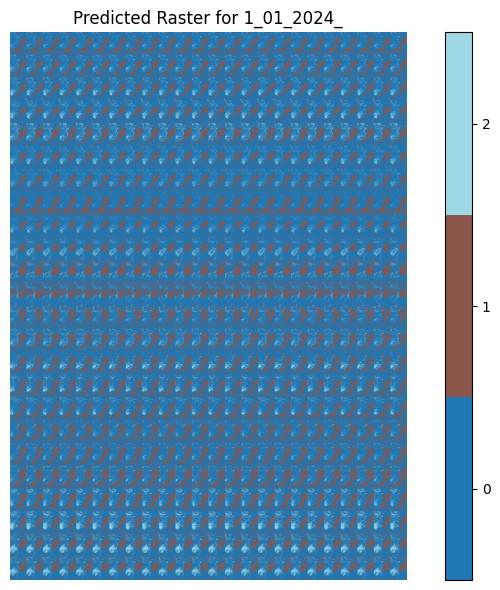

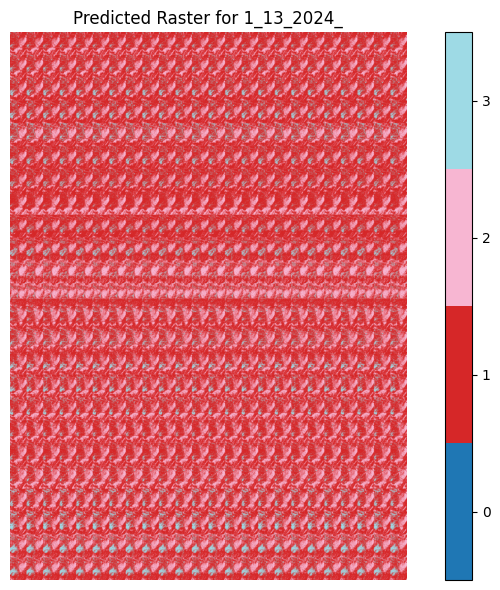

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

for label, data in label_rasters.items():
    # Ensure data is a NumPy array and reshape to 2D
    data = np.array(data).reshape(height, width)

    # Identify unique classes and map them to integers
    unique_classes = np.unique(data)
    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    int_data = np.vectorize(class_to_int.get)(data)

    # Create a categorical colormap
    cmap = plt.get_cmap('tab20', len(unique_classes))

    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(int_data, cmap=cmap)
    plt.title(f"Predicted Raster for {label}")
    cbar = plt.colorbar(im, ticks=range(len(unique_classes)))
    cbar.ax.set_yticklabels(unique_classes)
    plt.clim(-0.5, len(unique_classes) - 0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for label, data in label_rasters.items():
    # Convert to NumPy array and reshape
    data = np.array(data).reshape(height, width)

    # Map string labels to integers for plotting
    unique_labels = np.unique(data)
    label_to_int = {lbl: i for i, lbl in enumerate(unique_labels)}
    int_data = np.vectorize(label_to_int.get)(data)

    # Create a categorical colormap
    cmap = plt.get_cmap('tab20', len(unique_labels))

    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(int_data, cmap=cmap)
    plt.title(f"Predicted Raster for {label}")
    cbar = plt.colorbar(im, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)  # Show original string labels
    plt.clim(-0.5, len(unique_labels) - 0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Prepare raster data (VV,VH and PR) for predictions

In [ ]:
n_dates, height, width, n_bands = master_data.shape

# Reshape to (n_pixels, n_dates * n_bands) → shape: (height * width, 72)
pixel_data = master_data.transpose(1, 2, 0, 3).reshape(height * width, n_dates * n_bands)

# Clean and impute missing data

In [ ]:
nan_mask = np.isnan(pixel_data).any(axis=1)
pixel_data[nan_mask] = 0  # Replace NaNs with zeros or use imputation

# Plot and visualizing forecasting images

In [ ]:
prediction_maps = {}

for date in label_columns:
    model = models[date]
    preds = model.predict(pixel_data)
    preds[nan_mask] = -1  # Assign -1 to invalid predictions
    prediction_maps[date] = preds.reshape(height, width)

In [ ]:
with rasterio.open(os.path.join(vh_path, vh_files[0])) as ref:
    profile = ref.profile
    profile.update(dtype='int16', count=1, nodata=-1)  # ✅ Fix: valid nodata for int16

    for date, pred_map in prediction_maps.items():
        out_path = f"prediction_map_{date}.tif"
        with rasterio.open(out_path, 'w', **profile) as dst:
            dst.write(pred_map.astype('int16'), 1)

In [ ]:
import matplotlib.pyplot as plt

for date in list(prediction_maps.keys())[:5]:
    plt.imshow(prediction_maps[date], cmap='tab10')
    plt.title(f"Prediction Map: {date}")
    plt.axis('off')
    plt.colorbar()
    plt.show()

## Visualize forecast RF in each image

In [ ]:
classified_stack = []

for i in range(master_data.shape[0]):
    img = master_data[i]  # (height, width, 2)
    height, width = img.shape[:2]
    img_flat = img.reshape(-1, 2)

    predicted_labels = best_rf.predict(img_flat)
    predicted_raster = predicted_labels.reshape(height, width)

    classified_stack.append(predicted_raster)

In [ ]:
# Run the following code to visualize all images

'''
for i, classified_img in enumerate(classified_stack):
    plt.figure(figsize=(8, 6))
    plt.imshow(classified_img, cmap='tab10')
    plt.title(f"Classified Map - Scene {i+1}")
    plt.axis('off')
    plt.colorbar(label='Class Labels')
    plt.show()
'''